# Load libraries

In [1]:
import _pickle as cPickle
import numpy as np
from scipy.stats import spearmanr, scoreatpercentile
from scipy.sparse.linalg import svds
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import kneighbors_graph
import time
%pylab inline
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import PIL
from skimage import color
from skimage import io
import cv2

Populating the interactive namespace from numpy and matplotlib


Image Properties
- Number of Pixels: 1620000
- Shape/Dimensions: (900, 600, 3)


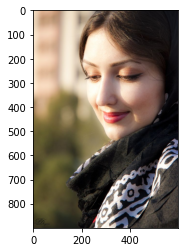

In [2]:
# load image

Image = mpimg.imread('persian_girl.jpg')
print("Image Properties")
print("- Number of Pixels: " + str(Image.size))
print("- Shape/Dimensions: " + str(Image.shape))
plt.imshow(Image)

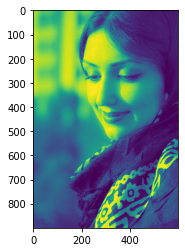

In [3]:
# rgb to gray
blue, green, red = cv2.split(Image) 
img_g = cv2.imread('persian_girl.jpg', cv2.IMREAD_GRAYSCALE) 
# cv2.imwrite('persian_girl_gray.jpg', img_g)

plt.imshow(img_g)

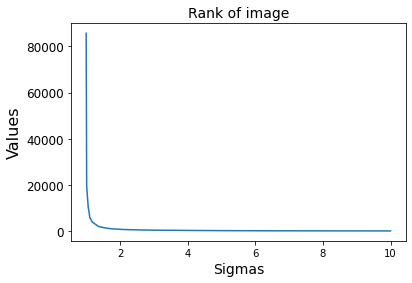

In [4]:
u, s, vh = np.linalg.svd(img_g, full_matrices=True)
plt.yticks(fontsize=12)

x = np.linspace(1,10,600)
plt.ylabel('Values', fontsize=16)
plt.xlabel('Sigmas', fontsize=14)
plt.title('Rank of image', fontsize=14)
plt.plot(x,s)
plt.savefig('persian_girl_gray_sigma.jpeg')

# Add noise function

In [5]:
def pepper_salt_noise(p,image):
    m, n = image.shape
    frac = 1- p
    sample = np.random.binomial(1, frac, size=m*n)
    mask = np.reshape(sample, (m, n))
    image_noise = image * mask
    return mask, image_noise

# Add different rate of noise

In [6]:
mask = []
image_noise = []
img = img_g

p = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
for i in p:
    pepper_salt_noise(i, img_g)
    mask.append(pepper_salt_noise(i, img)[0])
    image_noise.append(pepper_salt_noise(i, img)[1])

# plot noisy images

/home/hekmat/.local/lib/python3.6/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # Remove the CWD from sys.path while we load stuff.


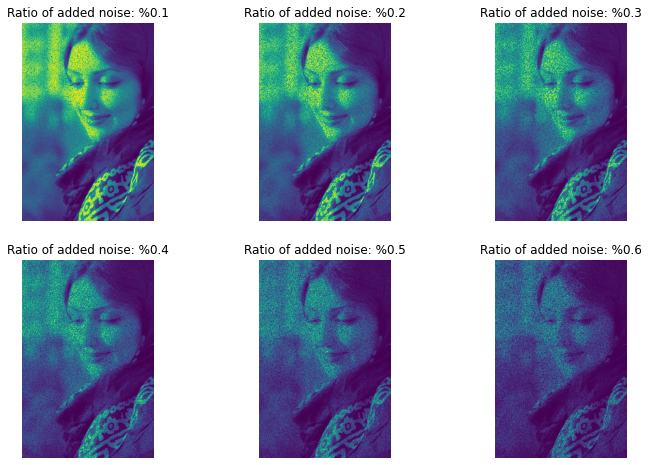

In [7]:
fig = plt.figure(figsize=(12, 8))
columns = 3
rows = 2

ax = []
for i in range(0, len(image_noise)):
    img = image_noise[i]
    ax.append(fig.add_subplot(rows, columns, i+1))
    ax[-1].set_title("Ratio of added noise: ""%"+str(p[i]))
    fig.add_subplot(rows, columns, i+1).set_axis_off()
    plt.imshow(img)
    

# cv2.imwrite('persian_girl_noised_0.1.jpg', image_noise[0])
# cv2.imwrite('persian_girl_noised_0.2.jpg', image_noise[1])
# cv2.imwrite('persian_girl_noised_0.3.jpg', image_noise[2])
# cv2.imwrite('persian_girl_noised_0.4.jpg', image_noise[3])
# cv2.imwrite('persian_girl_noised_0.5.jpg', image_noise[4])
# cv2.imwrite('persian_girl_noised_0.6.jpg', image_noise[5])
plt.show()

# Similarity measuring before denoising

In [8]:
from skimage.measure import compare_ssim as ssim
import warnings
warnings.filterwarnings("ignore")
initial_err = []
print("similarity between original image and noised image: \n")

for i in range(len(image_noise)):
    initial_err.append(ssim(img_g, image_noise[i]))
    print("noise ratio: ",p[i],"      ","similarity",": ", initial_err[i])


similarity between original image and noised image: 

noise ratio:  0.1        similarity :  0.3510727790684681
noise ratio:  0.2        similarity :  0.2641718490199499
noise ratio:  0.3        similarity :  0.21646317308356072
noise ratio:  0.4        similarity :  0.18417741391874903
noise ratio:  0.5        similarity :  0.15541952344176985
noise ratio:  0.6        similarity :  0.13040634478983978


# SVT

In [9]:
for i in range(len(image_noise)):
    image_noise[i] = image_noise[i].astype(float)

In [10]:
from tqdm import tqdm
Denoised_Image0=[]
Denoised_Image1=[]
Denoised_Image2=[]
Denoised_Image3=[]
Denoised_Image4=[]
Denoised_Image5=[]
Sigma0=[]
Sigma1=[]
Sigma2=[]
Sigma3=[]
Sigma4=[]
Sigma5=[]

svd_k = [10, 50, 100]#Top k largest singular values
svd_maxiter = 100 #The maximal number of iterations for svd
svt_delta = [0.5, 1.5, 1.7, 1.9]#The learning rate for SVT
e=0.0001# Error rate bound for stopping iteration
svt_maxiter=100#The maximal number of iterations for SVT

for j in tqdm(svd_k):
    for k in tqdm(svt_delta):
        
        def svt_feature(mat,
                        M = None,
                        svd_k = j,
                        svd_maxiter = 100,
                        svt_delta = k,
                        e=0.0001,
                        svt_maxiter=100
                       ):    

            if M is None :
                idx1 = np.where(mat!=0)[0]
                idx2 = np.where(mat!=0)[1]
                M = mat[idx1, idx2]
            else:
                idx1 = np.array(M[:,0], dtype='int')
                idx2 = np.array(M[:,1], dtype='int')
                M = M[:,2]
            tic = time.time()
            # Efficient svd implementation from scipy
            U,s,V = svds(mat, k = svd_k, maxiter = svd_maxiter)
            loop = 0
            i = 0
            err = 100    # Initial error set a large number
            # First svd approximation
            Y = U.dot(np.diag(s)).dot(V)
            while err > e and i <= svt_maxiter:
                Y[idx1, idx2] += svt_delta * (M - Y[idx1, idx2])
                U,s,V = svds(Y, k = svd_k, maxiter=svd_maxiter)
                Y = U.dot(np.diag(s)).dot(V)
                i += 1
                err = np.sum((M - Y[idx1, idx2])**2) / np.sum(M**2)
                if i % 10 == 0:
                    c = np.corrcoef(U.dot(np.diag(np.sqrt(s))))

            X = U.dot(np.diag(np.sqrt(s)))
            return X,Y
        s0, im0 = svt_feature(image_noise[0])
        s1, im1 = svt_feature(image_noise[1])
        s2, im2 = svt_feature(image_noise[2])
        s3, im3 = svt_feature(image_noise[3])
        s4, im4 = svt_feature(image_noise[4])
        s5, im5 = svt_feature(image_noise[5])

        Denoised_Image0.append(im0)
        Denoised_Image1.append(im1)
        Denoised_Image2.append(im2)
        Denoised_Image3.append(im3)
        Denoised_Image4.append(im4)
        Denoised_Image5.append(im5)
        
        Sigma0.append(s0)
        Sigma1.append(s1)
        Sigma2.append(s2)
        Sigma3.append(s3)
        Sigma4.append(s4)
        Sigma5.append(s5)
        
        

In [11]:
den_err0 = []
den_err1 = []
den_err2 = []
den_err3 = []
den_err4 = []
den_err5 = []

for i in range(len(Denoised_Image0)):
    den_err0.append(ssim(img_g, Denoised_Image0[i]))
    den_err1.append(ssim(img_g, Denoised_Image1[i]))
    den_err2.append(ssim(img_g, Denoised_Image2[i]))
    den_err3.append(ssim(img_g, Denoised_Image3[i]))
    den_err4.append(ssim(img_g, Denoised_Image4[i]))
    den_err5.append(ssim(img_g, Denoised_Image5[i]))
    
print("noise ratio ",p[0])
print("similarities",": ", den_err0)
print(" ")
print("noise ratio ",p[1])
print("similarities",": ", den_err1)
print(" ")
print("noise ratio ",p[2])
print("similarities",": ", den_err2)
print(" ")
print("noise ratio ",p[3])
print("similarities",": ", den_err3)
print(" ")
print("noise ratio ",p[4])
print("similarities",": ", den_err4)
print(" ")
print("noise ratio ",p[5])
print("similarities",": ", den_err5)

noise ratio  0.1
similarities :  [0.6787499501163636, 0.6475610354774585, 0.613868281171564, 0.5214280344142164, 0.8348215668590835, 0.8064641205282241, 0.7567138698536989, 0.6686014136102532, 0.898362226914412, 0.880238530766522, 0.8402890387345551, 0.7555641800037118]
 
noise ratio  0.2
similarities :  [0.6739921066010086, 0.6644254343985525, 0.6450045960264266, 0.5981664433127956, 0.8279000056036472, 0.8161690293982213, 0.7808709174431036, 0.7102868218783549, 0.8599413818230878, 0.8737016624227685, 0.8462648084303466, 0.7720777560296554]
 
noise ratio  0.3
similarities :  [0.6673862786198337, 0.6673938217453576, 0.6572098365201251, 0.6391588189693204, 0.8184997161590465, 0.8195402126190812, 0.8030418551196843, 0.7507838158319361, 0.7954250530568648, 0.8235246876528854, 0.8350498413966152, 0.7857094821018193]
 
noise ratio  0.4
similarities :  [0.6595433690964146, 0.6595518157967905, 0.6595518157967197, 0.6528528548558846, 0.8014303162080876, 0.8029046950353638, 0.8033612323180586, 0

In [12]:
ims = [den_err0,den_err1,den_err2,den_err3,den_err4,den_err5]

<Figure size 432x288 with 0 Axes>

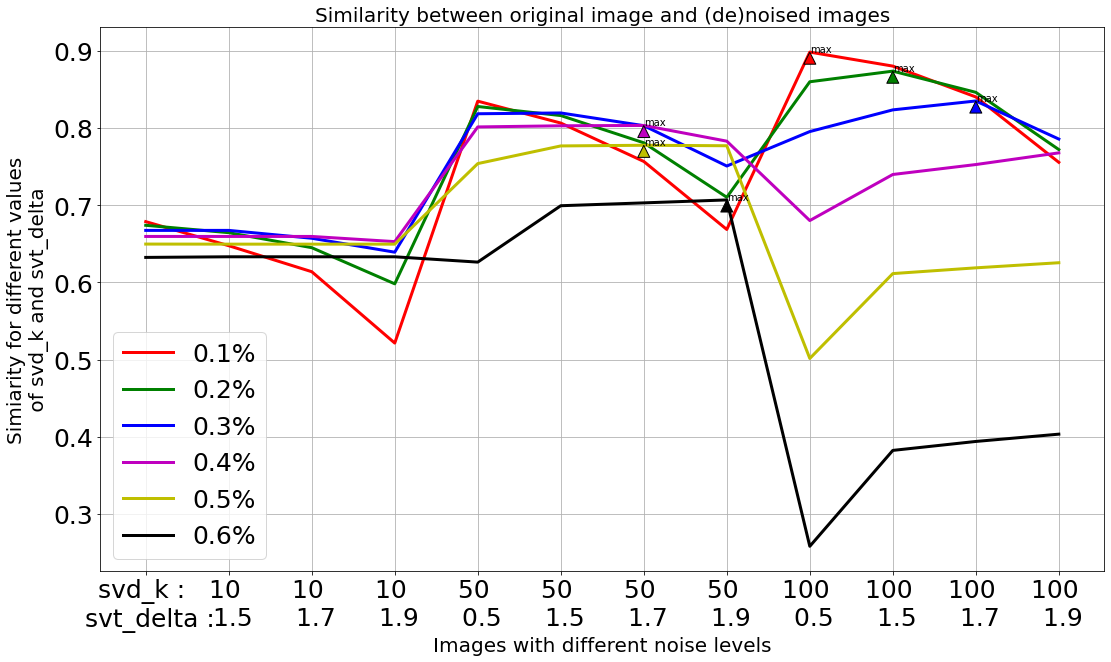

In [63]:
fig = plt.figure()
plt.figure(figsize=(18,10))
# plt.xticks(np.arange(0,12,1), fontsize=10)

x = np.arange(0,12,1)
y = ["svd_k : \n svt_delta :",
     "10 \n 1.5",
     "10 \n 1.7",
     "10 \n 1.9",
     "50 \n 0.5",
     "50 \n 1.5",
     "50 \n 1.7",
     "50 \n 1.9",
     "100 \n 0.5",
     "100 \n 1.5",
     "100 \n 1.7",
     "100 \n 1.9"]

ymax0 = max(den_err0)
xpos0 = den_err0.index(ymax0)
xmax0 = x[xpos0]
plt.annotate('max', xy=(xmax0, ymax0),arrowprops=dict(facecolor='r', shrink=0.05))

ymax1 = max(den_err1)
xpos1 = den_err1.index(ymax1)
xmax1 = x[xpos1]
plt.annotate('max', xy=(xmax1, ymax1),arrowprops=dict(facecolor='g', shrink=0.05))

ymax2 = max(den_err2)
xpos2 = den_err2.index(ymax2)
xmax2 = x[xpos2]
plt.annotate('max', xy=(xmax2, ymax2),arrowprops=dict(facecolor='b', shrink=0.05))

ymax3 = max(den_err3)
xpos3 = den_err3.index(ymax3)
xmax3 = x[xpos3]
plt.annotate('max', xy=(xmax3, ymax3),arrowprops=dict(facecolor='m', shrink=0.05))

ymax4 = max(den_err4)
xpos4 = den_err4.index(ymax4)
xmax4 = x[xpos4]
plt.annotate('max', xy=(xmax4, ymax4),arrowprops=dict(facecolor='y', shrink=0.05))

ymax5 = max(den_err5)
xpos5 = den_err5.index(ymax5)
xmax5 = x[xpos5]
plt.annotate('max', xy=(xmax5, ymax5),arrowprops=dict(facecolor='k', shrink=0.05))

plt.plot(y,den_err0,"r", label= "0.1%",LineWidth= 3)
plt.plot(y,den_err1,"g", label= "0.2%",LineWidth= 3)
plt.plot(y,den_err2,"b", label= "0.3%",LineWidth= 3)
plt.plot(y,den_err3,"m", label= "0.4%",LineWidth= 3)
plt.plot(y,den_err4,"y", label= "0.5%",LineWidth= 3)
plt.plot(y,den_err5,"k", label= "0.6%",LineWidth= 3)

plt.legend(loc = 0, fontsize=25)

plt.xticks(size = 25)
plt.yticks(size = 25)
plt.grid()
plt.ylabel('Simiarity for different values\n of svd_k and svt_delta ', fontsize=20)
plt.xlabel('Images with different noise levels', fontsize=20)
plt.title('Similarity between original image and (de)noised images', fontsize=20)
plt.savefig('optimization.jpeg')
plt.show()

# plot recovered images(SVT)

In [14]:
Denoised_Images = [Denoised_Image0,Denoised_Image1,Denoised_Image2,Denoised_Image3,Denoised_Image4,Denoised_Image5]


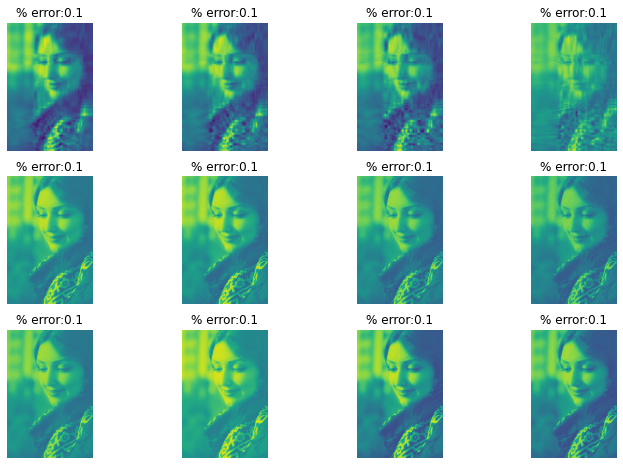

True

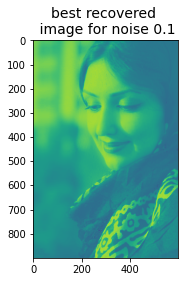

In [15]:
fig = plt.figure(figsize=(12, 8))
columns = 4
rows = 3

ax = []

for i in range(0, len(Denoised_Image0)):
    img = Denoised_Image0[i]
    ax.append(fig.add_subplot(rows, columns, i+1))
    ax[-1].set_title("% error:"+str(p[0]))
    fig.add_subplot(rows, columns, i+1).set_axis_off()

    plt.imshow(img)

plt.show()
plt.title('best recovered \n image for noise '+str(p[0]), fontsize=14)
#plot/save the best recovered image
plt.imshow(Denoised_Image0[xpos0])
cv2.imwrite('persian_girl_denoised_0.1.jpg', Denoised_Image0[xpos0])

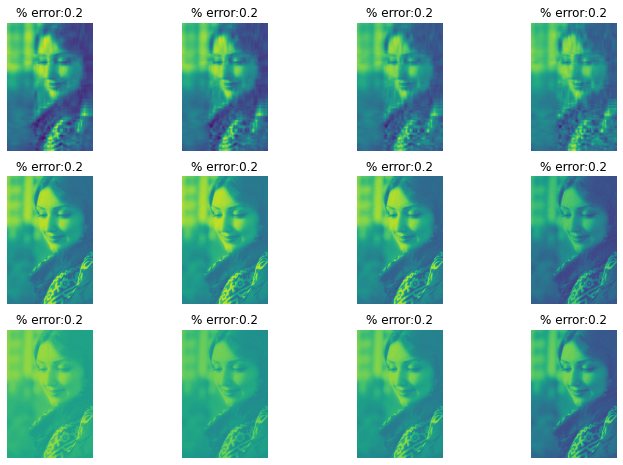

True

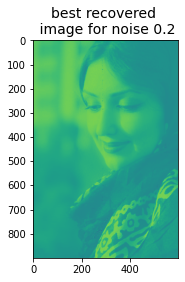

In [16]:
fig = plt.figure(figsize=(12, 8))
columns = 4
rows = 3

ax = []

for i in range(0, len(Denoised_Image1)):
    img = Denoised_Image1[i]
    ax.append(fig.add_subplot(rows, columns, i+1))
    ax[-1].set_title("% error:"+str(p[1]))
    fig.add_subplot(rows, columns, i+1).set_axis_off()

    plt.imshow(img)
    
plt.show()
plt.title('best recovered \n image for noise '+str(p[1]), fontsize=14)
#plot/save the best recovered image
plt.imshow(Denoised_Image1[xpos1])
cv2.imwrite('persian_girl_denoised_0.2.jpg', Denoised_Image1[xpos1])

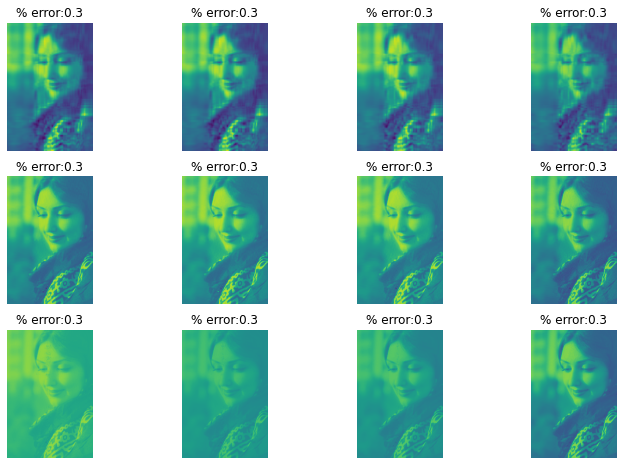

True

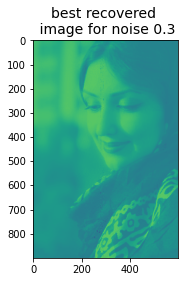

In [17]:
fig = plt.figure(figsize=(12, 8))
columns = 4
rows = 3

ax = []

for i in range(0, len(Denoised_Image2)):
    img = Denoised_Image2[i]
    ax.append(fig.add_subplot(rows, columns, i+1))
    ax[-1].set_title("% error:"+str(p[2]))
    fig.add_subplot(rows, columns, i+1).set_axis_off()

    plt.imshow(img)
    
plt.show()
plt.title('best recovered \n image for noise '+str(p[2]), fontsize=14)
#plot/save the best recovered image
plt.imshow(Denoised_Image2[xpos2])
cv2.imwrite('persian_girl_denoised_0.3.jpg', Denoised_Image2[xpos2])

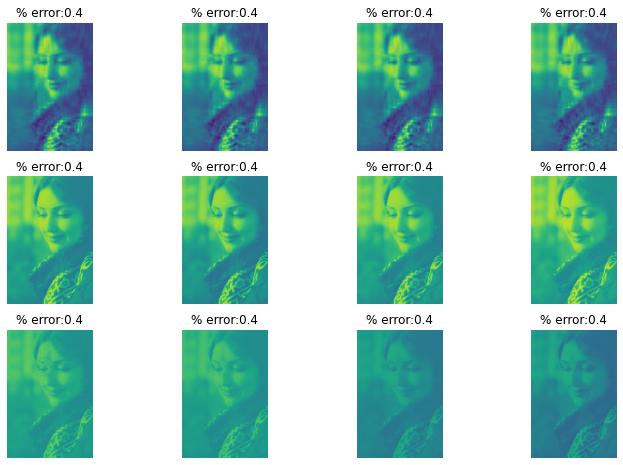

True

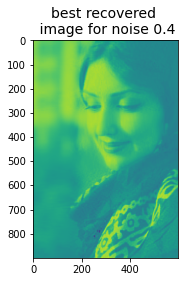

In [18]:
fig = plt.figure(figsize=(12, 8))
columns = 4
rows = 3

ax = []

for i in range(0, len(Denoised_Image3)):
    img = Denoised_Image3[i]
    ax.append(fig.add_subplot(rows, columns, i+1))
    ax[-1].set_title("% error:"+str(p[3]))
    fig.add_subplot(rows, columns, i+1).set_axis_off()

    plt.imshow(img)

plt.show()
plt.title('best recovered \n image for noise '+str(p[3]), fontsize=14)
#plot/save the best recovered image
plt.imshow(Denoised_Image3[xpos3])
cv2.imwrite('persian_girl_denoised_0.4.jpg', Denoised_Image3[xpos3])

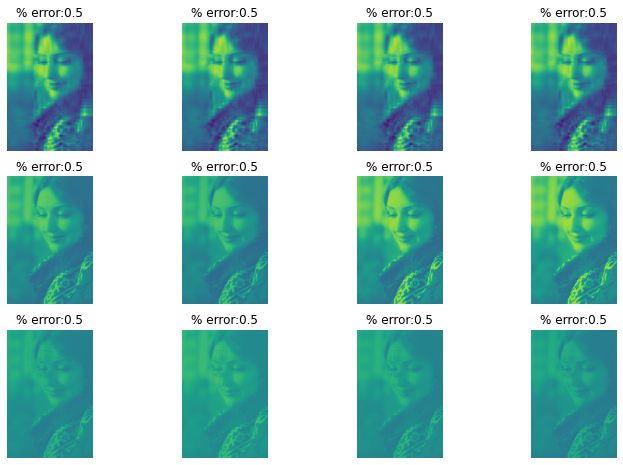

True

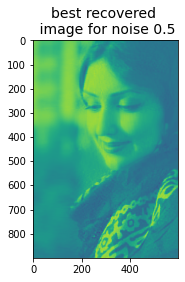

In [19]:
fig = plt.figure(figsize=(12, 8))
columns = 4
rows = 3

ax = []

for i in range(0, len(Denoised_Image4)):
    img = Denoised_Image4[i]
    ax.append(fig.add_subplot(rows, columns, i+1))
    ax[-1].set_title("% error:"+str(p[4]))
    fig.add_subplot(rows, columns, i+1).set_axis_off()

    plt.imshow(img)
    
plt.show()
plt.title('best recovered \n image for noise '+str(p[4]), fontsize=14)
#plot/save the best recovered image
plt.imshow(Denoised_Image4[xpos4])
cv2.imwrite('persian_girl_denoised_0.5.jpg', Denoised_Image4[xpos4])

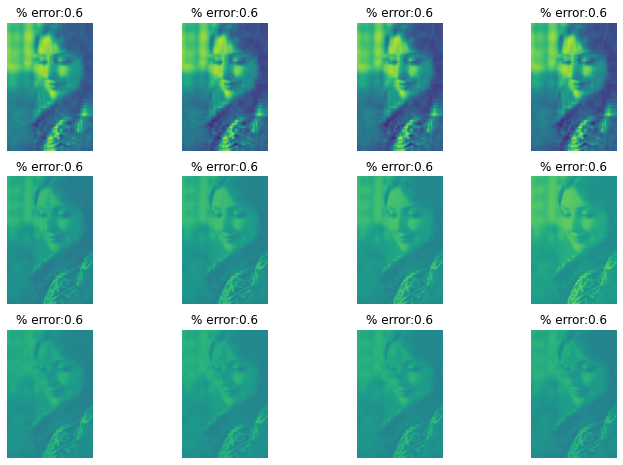

True

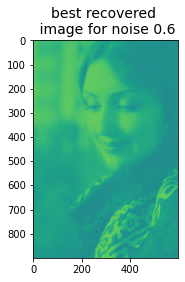

In [20]:
fig = plt.figure(figsize=(12, 8))
columns = 4
rows = 3

ax = []

for i in range(0, len(Denoised_Image5)):
    img = Denoised_Image5[i]
    ax.append(fig.add_subplot(rows, columns, i+1))
    ax[-1].set_title("% error:"+str(p[5]))
    fig.add_subplot(rows, columns, i+1).set_axis_off()

    plt.imshow(img)
    
plt.show()
plt.title('best recovered \n image for noise '+str(p[5]), fontsize=14)
#plot/save the best recovered image
plt.imshow(Denoised_Image5[xpos5])
cv2.imwrite('persian_girl_denoised_0.6.jpg', Denoised_Image5[xpos5])

In [21]:
denoised_err = []
print("similarity between original image and denoised image: \n")

denoised_err.append(ssim(img_g, Denoised_Image0[8]))
denoised_err.append(ssim(img_g, Denoised_Image1[9]))
denoised_err.append(ssim(img_g, Denoised_Image2[10]))
denoised_err.append(ssim(img_g, Denoised_Image3[5]))
denoised_err.append(ssim(img_g, Denoised_Image4[7]))
denoised_err.append(ssim(img_g, Denoised_Image5[7]))
print("similarity",": ", denoised_err)

similarity between original image and denoised image: 

similarity :  [0.898362226914412, 0.8737016624227685, 0.8350498413966152, 0.8029046950353638, 0.7770537957747383, 0.7068732959999484]


<Figure size 432x288 with 0 Axes>

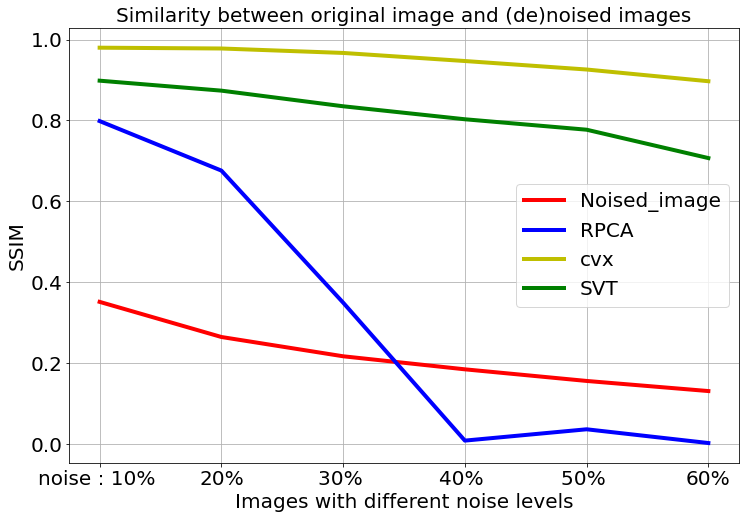

In [45]:
fig = plt.figure()
plt.figure(figsize=(12,8))

y = ["noise : 10% ","20%","30% ","40% ","50% ","60%"]
RPCA = [0.7984, 0.6759, 0.3492, 0.0078, 0.0358, 0.0018]
cvx = [0.980, 0.978, 0.967, 0.947, 0.926, 0.897]
plt.plot(y,initial_err, 'r', label='Noised_image',LineWidth= 4)
plt.plot(y,RPCA,'b', label='RPCA',LineWidth= 4)
plt.plot(y,cvx,'y', label='cvx',LineWidth= 4)
plt.plot(y,denoised_err,'g', label='SVT',LineWidth= 4)

plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
fig.suptitle("Singular Value Distribution", fontsize=20)
plt.xlabel("Index", fontsize=16)
plt.ylabel("Values", fontsize=16)
plt.ylabel('SSIM', fontsize=20)
plt.xlabel('Images with different noise levels', fontsize=20)
plt.title('Similarity between original image and (de)noised images', fontsize=20)


plt.legend(loc = 0, fontsize=20)

plt.xticks(size = 20)
plt.yticks(size = 20)
# fig.savefig('svd.jpg', dpi=600)
plt.savefig('Similarity_graph.jpeg', dpi=600)

plt.grid()